This File is to run the TVDN algorithm on AD and Control data and save the results for tha raw data

(**I didn't consider the selection at this stage**)

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat, savemat
import numpy as np
from easydict import EasyDict as edict
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import signal
from tqdm import tqdm
import pandas as pd
import pickle
%matplotlib inline

In [3]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD")
resDir = Path("./results")
dataDir = Path("./data")

In [5]:
import mat73
filAll = "smallraw.mat"
filAllDat = loadmat(dataDir/filAll)

In [34]:
RIDs = [ix[0].split("A")[0]  for ix in filAllDat["smallraw"][0][0][1][0]]
datAll = filAllDat["smallraw"][0][0][0][0]

In [35]:
# the order of RIDs after source identification
RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 
RID_Ctrl_labs_Add = loadmat("./OtherFils/radid_control_add.mat")["radid"].reshape(-1)
CtrllabsAdd = [lab[0] for lab in RID_Ctrl_labs_Add] 
CtrllabsBoth = Ctrllabs + CtrllabsAdd

### Run TVDN

In [38]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = None
paras.lamb = 1e-4 # it is what I used
paras.T = 2
paras.is_detrend = True
paras.decimateRate = None
paras.kappa = 3.005
paras.downRate = 100
paras.mFct = 1e15

if paras.decimateRate is None:
    paras.freq = 60
else:
    paras.freq = int(60/paras.decimateRate)

In [77]:
# sampling freq is 60Hz as decimate rate is 10. 
sos = signal.butter(N=50, Wn=[1, 40], btype='bp', fs=60, output='sos') # filter
kps = np.linspace(1, 4, 1000)

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=60 -> fs/2=30.0)

In [52]:
# AD 
for idx, cLab in enumerate(tqdm(ADlabs)):
    sIdx = np.where(cLab == np.array(RIDs))[0][0]
    curDat = datAll[sIdx].T * paras.mFct
    if sIdx == 105:
        curDat = np.delete(curDat, 27, axis=0)
    filtered = signal.sosfilt(sos, curDat)
    detAD = TVDNDetect(Ymat=filtered, dataType="MEG", 
                             saveDir=None, 
                             showProgress=False, 
                             fName="demoMEG",
                             MaxM=paras.MaxM,
                             Lmin=paras.Lmin, 
                             lamb=paras.lamb, 
                             kappa=paras.kappa, 
                             freq=paras.freq,
                             r=paras.r,
                             T=paras.T,
                             is_detrend=paras.is_detrend,
                             decimateRate=paras.decimateRate, 
                             downRate=paras.downRate)
    detAD.Screening(wh=paras.wh)
    detAD()
    detAD.TuningKappa(kps)
        
    saveFil = f"ADraw2_data_det_{idx}_lamb{paras.lamb:.1E}_decimate1.pkl"
    with open(resDir/saveFil, "wb") as f:
        pickle.dump(detAD, f)

100%|██████████| 88/88 [33:07<00:00, 22.58s/it]


In [53]:
# Ctrl
for idx, cLab in enumerate(tqdm(CtrllabsBoth)):
    sIdx = np.where(cLab == np.array(RIDs))[0][0]
    curDat = datAll[sIdx].T * paras.mFct
    if sIdx == 105:
        curDat = np.delete(curDat, 27, axis=0)
    filtered = signal.sosfilt(sos, curDat)
    detCtrl = TVDNDetect(Ymat=filtered, dataType="MEG", 
                             saveDir=None, 
                             showProgress=False, 
                             fName="demoMEG",
                             MaxM=paras.MaxM,
                             Lmin=paras.Lmin, 
                             lamb=paras.lamb, 
                             kappa=paras.kappa, 
                             freq=paras.freq,
                             r=paras.r,
                             T=paras.T,
                             is_detrend=paras.is_detrend,
                             decimateRate=paras.decimateRate, 
                             downRate=paras.downRate)
    detCtrl.Screening(wh=paras.wh)
    detCtrl()
    detCtrl.TuningKappa(kps)
        
    saveFil = f"Ctrlraw2_data_det_{idx}_lamb{paras.lamb:.1E}_decimate1.pkl"
    with open(resDir/saveFil, "wb") as f:
        pickle.dump(detCtrl, f)

100%|██████████| 92/92 [31:18<00:00, 20.42s/it]


### Save results

Note here I do not consider the order of the dataset, 
in fact for this part, order is not important.

In [54]:
numchgss = []
ps = list(resDir.glob("ADraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    numchgss.append(det.numchgs)
    
filName = f"ADraw2_data_lamb{det.paras.lamb:.1E}_Num.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(numchgss, f)

100%|██████████| 88/88 [06:34<00:00,  4.48s/it]


In [55]:
numchgss = []
ps = list(resDir.glob("Ctrlraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    numchgss.append(det.numchgs)
    
filName = f"Ctrlraw2_data_lamb{det.paras.lamb:.1E}_Num.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(numchgss, f)

100%|██████████| 92/92 [07:14<00:00,  4.72s/it]


### Sel a suitable kappa

In [56]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [57]:
curP = list(resDir.glob("Ctrlraw2_data*_Num.pkl"))[0]
with open(curP, "rb") as f:
    numchgss = pickle.load(f)

In [58]:
selNumChgss = np.array([ix for ix, kp in zip(numchgss, kpCtrl) if kp == 1])

In [59]:
optKp = kps[np.argmin(np.abs(selNumChgss.mean(axis=0)-4))]
optKp

2.4174174174174174

In [60]:
ecptss = []
ps = list(resDir.glob("Ctrlraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"Ctrlraw2_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

100%|██████████| 92/92 [06:33<00:00,  4.28s/it]


In [61]:
ecptss = []
ps = list(resDir.glob("ADraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"ADraw2_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

100%|██████████| 88/88 [06:31<00:00,  4.45s/it]


In [62]:
def GetFeatures(det):
    """
    obtain the eigvals and eigvectors for current ecpts
    """
    if det.RecResCur is None:
        det.GetRecResCur()
    Ur = det.midRes.eigVecs[:, :det.paras.r]
        
    lamMs = []
    for idx, ecpt in enumerate(np.concatenate([[0], det.ecpts])):
        lamM = det.RecResCur.LamMs[:, int(ecpt)]
        lamMs.append(lamM)
    
    det.curEigVecs = Ur
    det.curEigVals = lamMs

In [63]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("Ctrlraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"Ctrlraw2_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"Ctrlraw2_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 92/92 [06:21<00:00,  4.15s/it]


In [64]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("ADraw2_*04_decimate1.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"ADraw2_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"ADraw2_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 88/88 [06:35<00:00,  4.49s/it]


### Analyze the results

In [65]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [66]:
# ecpts
fil = list(resDir.glob("ADraw2_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrlraw2_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [67]:
# Eigvals
fil = list(resDir.glob("ADraw2_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrlraw2_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [68]:
fil = list(resDir.glob("ADraw2_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrlraw2_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [69]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1]

In [70]:
# Dwell times in second
freq = 60
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [3600]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [3600]])/freq) for ecpts in ecptssCtrl]

In [71]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
  
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsAD = fsAll  

In [72]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

In [73]:
import seaborn as sns
import scipy

Text(0.5, 18.5, 'P-value: 0.627')

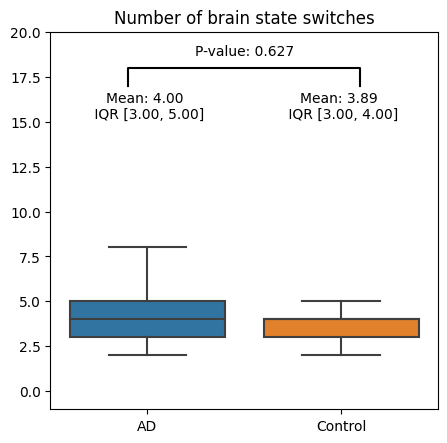

In [74]:
nchgsAD = [len(ecpts) for ecpts in ecptssAD]
nchgsCtrl = [len(ecpts) for ecpts in ecptssCtrl]
plt.figure(figsize=[5, 5], dpi=100)
sns.boxplot(data=[nchgsAD, nchgsCtrl],  showfliers=0)
plt.ylim([-1, 20])
plt.xticks([0, 1], ["AD", "Control"])
plt.title("Number of brain state switches")

txty, txtcol = 15,  "k"
txtxdlt = 0.4
ix = 0
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
txt1 = f"Mean: {np.mean(nchgsAD):.2f} \n IQR [{np.quantile(nchgsAD, 0.25):.2f}, {np.quantile(nchgsAD, 0.75):.2f}]"
plt.text((txtx1+txtx2)*.5, txty, txt1, ha='center', va='bottom', color=txtcol)

ix = 1
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
txt2 = f"Mean: {np.mean(nchgsCtrl):.2f} \n IQR [{np.quantile(nchgsCtrl, 0.25):.2f}, {np.quantile(nchgsCtrl, 0.75):.2f}]"
plt.text((txtx1+txtx2)*.5, txty, txt2, ha='center', va='bottom', color=txtcol)

txty, txtcol = 17,  "k"
ix = 0.5
txtxdlt = 0.6
txth = 1
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
res = scipy.stats.ttest_ind(nchgsAD, nchgsCtrl)
pv = res.pvalue
txt1 = f"P-value: {pv:.3f}"
#txt1 = f"ATE: {ATE:.2f}, P-value: {pv:.3f} "
plt.text((txtx1+txtx2)*.5, txty+txth+0.5, txt1, ha='center', va='bottom', color=txtcol)

Text(0.5, 26.5, 'P-value: 0.004')

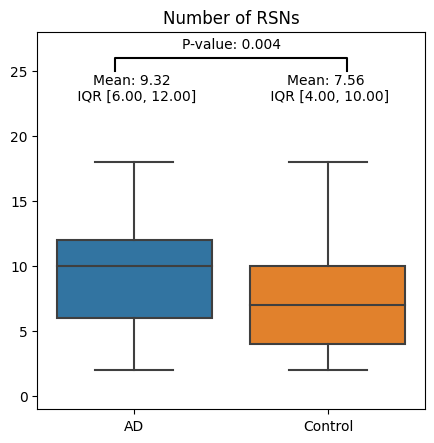

In [75]:
rksAD = [fs.r for fs in fsAD]
rksCtrl = [fs.r for fs in fsCtrl]
plt.figure(figsize=[5, 5], dpi=100)
sns.boxplot(data=[rksAD, rksCtrl], showfliers=0)
plt.ylim([-1, 28])
plt.xticks([0, 1], ["AD", "Control"])
plt.title("Number of RSNs")

txty, txth, txtcol = 23, -1, "k"
txtxdlt = 0.4
ix = 0
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
#plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
txt1 = f"Mean: {np.mean(rksAD):.2f} \n IQR [{np.quantile(rksAD, 0.25):.2f}, {np.quantile(rksAD, 0.75):.2f}]"
plt.text((txtx1+txtx2)*.5, txty+txth+0.5, txt1, ha='center', va='bottom', color=txtcol)

ix = 1
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
#plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
txt2 = f"Mean: {np.mean(rksCtrl):.2f} \n IQR [{np.quantile(rksCtrl, 0.25):.2f}, {np.quantile(rksCtrl, 0.75):.2f}]"
plt.text((txtx1+txtx2)*.5, txty+txth+0.5, txt2, ha='center', va='bottom', color=txtcol)

txty, txtcol = 25,  "k"
ix = 0.5
txtxdlt = 0.6
txth = 1
txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
res = scipy.stats.ttest_ind(rksAD, rksCtrl)
pv = res.pvalue
txt1 = f"P-value: {pv:.3f}"
plt.text((txtx1+txtx2)*.5, txty+txth+0.5, txt1, ha='center', va='bottom', color=txtcol)